# Load Data

In [1]:
from google.cloud import storage
import os
from io import BytesIO
import pandas as pd

#Connect to GCP bucket and assign the bucket_name and specify the file name
bucket_name = "lj-bucket1" #Assign the bucket name where your file is stored
storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)

In [2]:
# spark configuration
# I might be wrong, but even running 3G file on spark is very memory consuming

from pyspark import SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import *


conf = SparkConf().setAppName("App")
conf = (conf.set('spark.executor.memory', '30G')
            .set('spark.driver.memory', '30G')
            .set('spark.driver.maxResultSize', '30G'))

spark = SparkSession.builder\
                    .config(conf=conf)\
                    .appName('LJ')\
                    .getOrCreate()

In [3]:
blob = storage.blob.Blob("tracks_metadata.csv", bucket)
blob

<Blob: lj-bucket1, tracks_metadata.csv, None>

In [4]:
content = blob.download_as_string()
df = pd.read_csv(BytesIO(content))

In [5]:
# Convert Pandas Dataframe to Spark Dataframe with schema    

metadata_schema = StructType(
   [StructField('track_id', StringType(), True),
   StructField('title', StringType(), True),
   StructField('song_id', StringType(), True),
   StructField('release', StringType(), True),
   StructField('artist_id', StringType(), True),
   StructField('artist_mbid', StringType(), True),
   StructField('artist_name', StringType(), True),
   StructField('duration', DoubleType(), True),
   StructField('artist_familiarity', DoubleType(), True),
   StructField('artist_hotttness', DoubleType(), True),
   StructField('year', IntegerType(), True)]
)


metadata_df = spark.createDataFrame(df, schema=metadata_schema) 

In [6]:
# read csv directly from google cloud - RECOMMENDED
# pip install gcsfs
# should be <5 mins

df = pd.read_csv('gs://lj-bucket1/listening_history.csv')

In [7]:
# It seems this step requires huge Memory; 
# be sure to upgrade your system to at least 15GB RAM (>30GB RAM suggested)
# might take over 10 mins

history_schema = StructType(
  [StructField('user_id', StringType()),
   StructField('track_id', StringType()),
   StructField('frequency', IntegerType())]
)

history_df = spark.createDataFrame(df, schema=history_schema)

In [8]:
# take a quick look
history_df.show(5)

+--------------------+------------------+---------+
|             user_id|          track_id|frequency|
+--------------------+------------------+---------+
|b80344d063b5ccb32...|TRIQAUQ128F42435AD|        1|
|7c86176941718984f...|TRIQAUQ128F42435AD|        1|
|76235885b32c4e8c8...|TRIQAUQ128F42435AD|        3|
|250c0fa2a77bc6695...|TRIQAUQ128F42435AD|        1|
|3f73f44560e822344...|TRIQAUQ128F42435AD|        6|
+--------------------+------------------+---------+
only showing top 5 rows



# Preprocessing 

In [9]:
from pyspark.sql import functions as F

# change ids to int
user_id = history_df.select('user_id')\
                    .distinct()\
                    .select('user_id', F.monotonically_increasing_id()\
                    .alias('new_userid'))


track_id = history_df.select('track_id')\
                     .distinct()\
                     .select('track_id', F.monotonically_increasing_id()\
                     .alias('new_trackid'))

In [10]:
# get total unique users and songs
unique_users = user_id.count()
unique_tracks = track_id.count()
print('Number of unique users: {0}'.format(unique_users))
print('Number of unique songs: {0}'.format(unique_tracks))

Number of unique users: 1019318
Number of unique songs: 385256


### There are more than 1 Million Unique Users and More than 385K unique tracks.

In [11]:
# join all data
total_df = history_df.join(user_id, 'user_id')\
                     .join(track_id, 'track_id')

In [12]:
total_df.count()

49664528

### Let's make life easier...; as we are running the same algorithms anyway, and the memory on cloud is really expensive.

In [13]:
# cache in memory 
# because we will revisit them from time to time

metadata_df.cache()
total_df.cache()

DataFrame[track_id: string, user_id: string, frequency: int, new_userid: bigint, new_trackid: bigint]

In [14]:
# check memory usage
! free -m

              total        used        free      shared  buff/cache   available
Mem:         104741       30539       65017           8        9183       73039
Swap:             0           0           0


# EDAV

In [15]:
# count entries and listens
entries = total_df.count()

In [16]:
listens = []
for i in range(10):
    listens.append(float(total_df.filter(total_df.frequency == i+1).count())/entries*100)

In [17]:
numbers = [i for i in range(1, 11)]

d = {'number': numbers, 'listen': listens}
df = pd.DataFrame(data=d)
df

,number,listen
0,1,59.424320
1,2,15.196623
2,3,6.666688
3,4,3.747169
4,5,4.625289
5,6,2.076444
6,7,1.397007
7,8,1.011621
8,9,0.753538
9,10,0.892770


## Around 59.6% of the tracks are played at least once. 

Text(0.5, 1.0, 'Percentage of the Track Play Frequency')

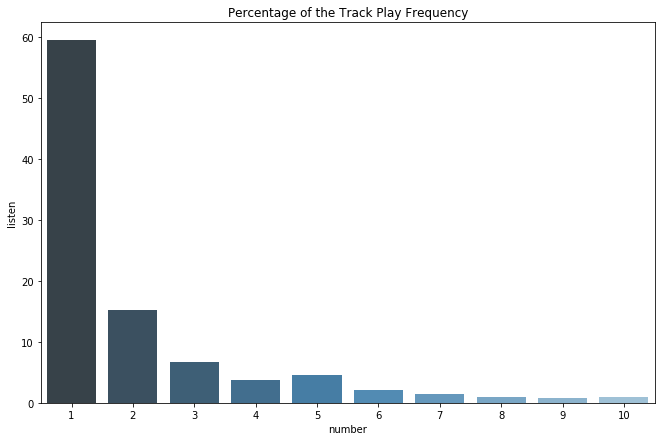

In [18]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(11, 7))
sns.barplot(x='number', y='listen', data=df, palette="Blues_d")
plt.title("Percentage of the Track Play Frequency")

In [19]:
import numpy as np

total_listens = np.cumsum(listens)
d = {'number': numbers, 'cummulative_listen': total_listens}
df = pd.DataFrame(data=d)
df

,number,cummulative_listen
0,1,59.424320
1,2,74.620943
2,3,81.287630
3,4,85.034800
4,5,89.660089
5,6,91.736533
6,7,93.133540
7,8,94.145161
8,9,94.898699
9,10,95.791469


## Almost 90% of the songs are played between 1 to 5 times. (<= 5 times)

Text(0.5, 1.0, 'Percentage of the Track Play Frequency')

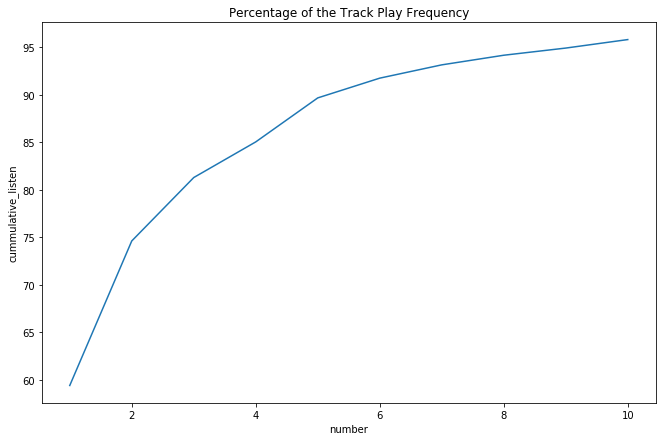

In [20]:
plt.figure(figsize=(11, 7))
sns.lineplot(x='number', y='cummulative_listen', data=df, palette="Blues_d")
plt.title("Percentage of the Track Play Frequency")

# Naive Recommendation - By popularity

In [21]:
tracks_with_listens = total_df.groupBy('track_id')\
                              .agg(F.count(total_df.frequency).alias('user_count'),
                                   F.sum(total_df.frequency).alias('total_frequency'))\
                              .orderBy('total_frequency', ascending = False)

tracks_with_listens.show(3, truncate=False)

+------------------+----------+---------------+
|track_id          |user_count|total_frequency|
+------------------+----------+---------------+
|TRAEHHJ12903CF492F|84000     |726885         |
|TRGXQES128F42BA5EB|90476     |648239         |
|TRONYHY128F92C9D11|80656     |527893         |
+------------------+----------+---------------+
only showing top 3 rows



In [22]:
# Join with metadata 
# Get detailed song information

tracks_with_listens_names = tracks_with_listens.join(metadata_df, 'track_id' ) \
                                               .filter('user_count >= 200') \
                                               .select('artist_name', 'title', 'user_count','total_frequency') \
                                               .orderBy('total_frequency', ascending = False)

# display 20 most popular songs
tracks_with_listens_names.show(n=10, truncate = False)

+----------------------------------------------------------------------+-------------------------------------------------------------------+----------+---------------+
|artist_name                                                           |title                                                              |user_count|total_frequency|
+----------------------------------------------------------------------+-------------------------------------------------------------------+----------+---------------+
|Dwight Yoakam                                                         |You're The One                                                     |84000     |726885         |
|Björk                                                                 |Undo                                                               |90476     |648239         |
|Kings Of Leon                                                         |Revelry                                                            |80656     |527893   

In [23]:
# try different display options
tracks_with_listens_names.show(n=10)

+--------------------+--------------------+----------+---------------+
|         artist_name|               title|user_count|total_frequency|
+--------------------+--------------------+----------+---------------+
|       Dwight Yoakam|      You're The One|     84000|         726885|
|               Björk|                Undo|     90476|         648239|
|       Kings Of Leon|             Revelry|     80656|         527893|
|            Harmonia|       Sehr kosmisch|    110479|         425463|
|Barry Tuckwell/Ac...|Horn Concerto No....|     69487|         389880|
|Florence + The Ma...|Dog Days Are Over...|     90444|         356533|
|         OneRepublic|             Secrets|     78353|         292642|
|    Five Iron Frenzy|              Canada|     46078|         274627|
|            Tub Ring|             Invalid|     37642|         268353|
|           Sam Cooke|    Ain't Misbehavin|     36976|         244730|
+--------------------+--------------------+----------+---------------+
only s

In [24]:
tracks_with_listens_names.select("artist_name", "title").show(n=10, truncate=False)

+----------------------------------------------------------------------+-------------------------------------------------------------------+
|artist_name                                                           |title                                                              |
+----------------------------------------------------------------------+-------------------------------------------------------------------+
|Dwight Yoakam                                                         |You're The One                                                     |
|Björk                                                                 |Undo                                                               |
|Kings Of Leon                                                         |Revelry                                                            |
|Harmonia                                                              |Sehr kosmisch                                                      |
|Barry Tuckwe

# Collaborative Filtering

Assumption: if person A and B share similar listening history, A might be also interested in B's other songs.

For this history, as for each user, we have song plays frequency for only a subset of the songs, because not all users listened to all songs. 

The intuition is that collaborative filtering would be able to approximate the matrix; which decompomise the matrix as the product of "user property" cross "song property".

I will do the optimiazation with ALS algorithm:

1. first randomly fill in the users matrix
2. optimize the song values that the error is minimized (least squared error)
3. then, hold song's value fixed and optimize the user matrix (that's why it's called alternation)

In [27]:
# train, validation, test  ---  0.6, 0.2, 0.2

train_df, valid_df, test_df = total_df.randomSplit([0.6, 0.2, 0.2])

In [28]:
# make sure all frequency in double type

train_df = train_df.withColumn("frequency", train_df["frequency"].cast(DoubleType()))
valid_df = valid_df.withColumn("frequency", valid_df["frequency"].cast(DoubleType()))
test_df = test_df.withColumn("frequency", test_df["frequency"].cast(DoubleType()))

In [29]:
# ALS has strict requirement for data type
# bigint is very problematic
# make bigint to int

train_df = train_df.withColumn("new_userid", train_df["new_userid"].cast(IntegerType()))
train_df = train_df.withColumn("new_trackid", train_df["new_trackid"].cast(IntegerType()))

valid_df = valid_df.withColumn("new_userid", valid_df["new_userid"].cast(IntegerType()))
valid_df = valid_df.withColumn("new_trackid", valid_df["new_trackid"].cast(IntegerType()))

test_df = test_df.withColumn("new_userid", test_df["new_userid"].cast(IntegerType()))
test_df = test_df.withColumn("new_trackid", test_df["new_trackid"].cast(IntegerType()))

In [30]:
# Cache those to save memory

train_df = train_df.cache()
valid_df = valid_df.cache()
test_df = test_df.cache()

In [31]:
train_df.show(5)

+------------------+--------------------+---------+----------+-----------+
|          track_id|             user_id|frequency|new_userid|new_trackid|
+------------------+--------------------+---------+----------+-----------+
|TRAADJU128F92F58E1|5a3417a1955d91364...|      1.0|       782|        870|
|TRAADQX128F422B4CF|00c54b607a321a950...|      1.0|      5085|        345|
|TRAADQX128F422B4CF|01cd07155ccfcfc50...|     13.0|      3051|        345|
|TRAADQX128F422B4CF|02f1fac05069ff021...|      6.0|      3998|        345|
|TRAADQX128F422B4CF|0389cf2c68d386b8c...|      1.0|      1404|        345|
+------------------+--------------------+---------+----------+-----------+
only showing top 5 rows



# ALS

In [32]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# initialization

als = ALS().setMaxIter(5)\
            .setItemCol("new_trackid")\
            .setRatingCol("frequency")\
            .setUserCol("new_userid")

In [33]:
# evaluation metric - RMSE

eval_metric = RegressionEvaluator(predictionCol="prediction",
                           labelCol="frequency",
                           metricName="rmse")

In [34]:
# hyper parameter space for cross validation - grid search

ranks = [6, 8, 10, 12, 14]
regParams = [0.2, 0.25, 0.3, 0.35]
errors = [[0]*len(ranks)]*len(regParams)
models = [[0]*len(ranks)]*len(regParams)
min_error = float('inf')
i = 0

In [35]:
for regParam in regParams:
    j = 0
    for rank in ranks:
        # grid search starts
        als.setParams(rank = rank, regParam = regParam)
        model = als.fit(train_df)
        
        # validation performance
        predict_df = model.transform(valid_df)

        # Remove NaN values from prediction
        predicted_plays_df = predict_df.filter(predict_df.prediction != float('nan'))
        predicted_plays_df = predicted_plays_df.withColumn("prediction", F.abs(F.round(predicted_plays_df["prediction"],0)))

        error = eval_metric.evaluate(predicted_plays_df)
        errors[i][j] = error
        models[i][j] = model
        print ('rank %s, regularization parameter %s the RMSE is %s' % (rank, regParam, error))
        if error < min_error:
            min_error = error
            best_params = [i,j]
        j += 1
    i += 1

rank 6, regularization parameter 0.2 the RMSE is 6.308745142581982
rank 8, regularization parameter 0.2 the RMSE is 6.311075749956096
rank 10, regularization parameter 0.2 the RMSE is 6.309891551356756
rank 12, regularization parameter 0.2 the RMSE is 6.31031605622553
rank 14, regularization parameter 0.2 the RMSE is 6.3096964880048665
rank 6, regularization parameter 0.25 the RMSE is 6.306776910793692
rank 8, regularization parameter 0.25 the RMSE is 6.307839557342152
rank 10, regularization parameter 0.25 the RMSE is 6.307985830644328
rank 12, regularization parameter 0.25 the RMSE is 6.308361116377259
rank 14, regularization parameter 0.25 the RMSE is 6.307658734396343
rank 6, regularization parameter 0.3 the RMSE is 6.308165838090979
rank 8, regularization parameter 0.3 the RMSE is 6.308449547110824
rank 10, regularization parameter 0.3 the RMSE is 6.308892568021059
rank 12, regularization parameter 0.3 the RMSE is 6.309016296429492
rank 14, regularization parameter 0.3 the RMSE is

### On the whole dataset, it doesn't help that much to tune the hyperparameter. 

In [36]:
# best parameters

als.setRegParam(regParams[best_params[0]])
als.setRank(ranks[best_params[1]])
print ('The best regularization parameter is %s' % regParams[best_params[0]])
print ('The best rank is %s' % ranks[best_params[1]])
my_model = models[best_params[0]][best_params[1]]

The best regularization parameter is 0.25
The best rank is 6


In [37]:
#Example of predicted plays
predicted_plays_df.show(10)

+------------------+--------------------+---------+----------+-----------+----------+
|          track_id|             user_id|frequency|new_userid|new_trackid|prediction|
+------------------+--------------------+---------+----------+-----------+----------+
|TRJUFSI128F42BA722|149c6088e2ff76512...|      1.0|       148|        148|       2.0|
|TRKOZVY12903CFDBD0|f2ae4721376a83b97...|     18.0|       148|        148|       2.0|
|TRPZOLS128F427EEFB|d8b77ab59b79b6cd9...|      1.0|       148|        148|       2.0|
|TRMPSGR128F92D31F3|999ca7ef5c7f1ad44...|      1.0|       148|        148|       2.0|
|TRHPMLM128F92F10C5|0981a87799e11bbc9...|      1.0|       148|        148|       2.0|
|TRDQRVE128F427BFAF|051574346cd47b612...|      1.0|       148|        148|       2.0|
|TRYJCWT128F42635D6|ba9cf21677846e06c...|      1.0|       148|        148|       2.0|
|TRRSGAK128E0786BAE|16a5d42ae7a16eac2...|      4.0|       463|        148|       3.0|
|TRXZKTY128F149ACD8|d376d833b4934d516...|      5.0|   

# Evaluation on test

In [38]:
predict_df = my_model.transform(test_df)

# Remove nan
predicted_test_df = predict_df.filter(predict_df.prediction != float('nan'))
# round to int
predicted_test_df = predicted_test_df.withColumn("prediction", F.abs(F.round(predicted_test_df["prediction"],0)))
test_RMSE = eval_metric.evaluate(predicted_test_df)

print('The final RMSE on the test set is {0}'.format(test_RMSE))

The final RMSE on the test set is 6.461274416023


### It seems to be a nice score. We need to examine the result to check if it can make sense.

# Evaluation on a specific user

In [39]:
# randomly assign a user
user = 101
tracks = total_df.filter(total_df.new_userid == user)\
                .join(metadata_df, 'track_id') \
                .select('new_trackid', 'artist_name', 'title') 

In [40]:
print("Tracks that user already listened to:")
tracks.show(10, truncate=False)

Tracks that user already listened to:
+------------+-----------------+-----------------------------------------------------+
|new_trackid |artist_name      |title                                                |
+------------+-----------------+-----------------------------------------------------+
|42949673382 |Spitalfield      |Those Days You Felt Alive (Album Version)            |
|137438953622|Yellowcard       |Fighting                                             |
|146028888098|Rise Against     |Audience Of One                                      |
|180388626438|Cage The Elephant|Back Against The Wall                                |
|206158430233|Rise Against     |Under The Knife                                      |
|214748364996|Gym Class Heroes |It's OK_ But Just This Once! (Explicit Album Version)|
|292057776186|Dr Feelgood      |Riot In Cell Block Number Nine                       |
|352187318273|Cage The Elephant|Ain't No Rest For The Wicked (Original Version)      |
|3607

In [41]:
# generate unlistened tracks

listened_track = []
for track in tracks.collect():
    listened_track.append(track['new_trackid'])
    
unlistened_track = total_df.filter(~ total_df['new_trackid'].isin(listened_track))\
                            .select('new_trackid')\
                            .withColumn('new_userid', F.lit(user))\
                            .distinct().select('new_userid', 'new_trackid')

In [42]:
# switch data type from bigint to int

unlistened_track = unlistened_track.withColumn("new_trackid", unlistened_track["new_trackid"].cast(IntegerType()))

In [43]:
predicted_listens = my_model.transform(unlistened_track).distinct()
predicted_listens = predicted_listens.filter(predicted_listens['prediction'] != float('nan'))

In [47]:
spark.conf.set("spark.sql.crossJoin.enabled", True)

In [48]:
predicted_listens.show(5)

+----------+-----------+----------+
|new_userid|new_trackid|prediction|
+----------+-----------+----------+
|       101|        463| 2.5012994|
|       101|       1946| 1.5643767|
|       101|       1231|  2.299659|
|       101|        533| 2.4257603|
|       101|         45|  2.432258|
+----------+-----------+----------+
only showing top 5 rows



In [50]:
print('Predicted Unlistened Tracks for user-id 101:')
pre = predicted_listens.join(total_df, 'new_trackid')\
                 .join(metadata_df, 'track_id')\
                 .select('artist_name', 'title', 'prediction')\
                 .distinct()\
                 .orderBy('prediction', ascending = False)\
                 
pre.show(10, truncate=False)

Predicted Unlistened Tracks for user-id 101:
+---------------+-----------------------------------+----------+
|artist_name    |title                              |prediction|
+---------------+-----------------------------------+----------+
|Martin Simpson |Pretty Saro / Long Steel Rail      |3.1813297 |
|Daft Punk      |Indo Silver Club                   |3.179399  |
|DJ Paul        |No More Wars In This World         |3.095704  |
|Mad Sin        |Gone Forever                       |3.0760639 |
|Joe Zawinul    |Arrival In New York (LP Version)   |3.0368576 |
|Ricky Fante    |Smile                              |2.9288943 |
|The Stooges    |Little Doll (Remastered LP Version)|2.902911  |
|Rancid         |Motorcycle Ride (Album Version)    |2.8918796 |
|John Mellencamp|Now More Than Ever                 |2.8734195 |
|Amon Amarth    |North Sea Storm                    |2.8329525 |
+---------------+-----------------------------------+----------+
only showing top 10 rows

